In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/MACHINE PROJECT/rs2_augmented.csv")

In [4]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["sentence1_clean"].tolist() + df["sentence2_clean"].tolist())

# Convert to sequences
s1_seq = tokenizer.texts_to_sequences(df["sentence1_clean"])
s2_seq = tokenizer.texts_to_sequences(df["sentence2_clean"])

# Pad sequences
max_len = 50
X1 = pad_sequences(s1_seq, maxlen=max_len, padding='post')
X2 = pad_sequences(s2_seq, maxlen=max_len, padding='post')
print(X1.shape)
y = df["score"].values


(482840, 50)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Lambda, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

# Train-validation split
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)

# Define parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

# Inputs
input1 = Input(shape=(max_len,))
input2 = Input(shape=(max_len,))

# Shared embedding + RNN encoder
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)

embedded1 = embedding_layer(input1)
embedded2 = embedding_layer(input2)
from tensorflow.keras.layers import GlobalAveragePooling1D
# Replace RNN with global average pooling followed by dense
pooled1 = GlobalAveragePooling1D()(embedded1)
pooled2 = GlobalAveragePooling1D()(embedded2)

dense1 = Dense(128, activation='relu')(pooled1)
dense2 = Dense(128, activation='relu')(pooled2)

abs_diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([dense1, dense2])
mult = Lambda(lambda x: x[0] * x[1])([dense1, dense2])

merged = concatenate([dense1, dense2, abs_diff, mult])
dense = Dense(128, activation='relu')(merged)
drop = Dropout(0.3)(dense)
output = Dense(1, activation='linear')(drop)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])



# Train
history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=10, batch_size=32
)
y_pred = model.predict([X1_val, X2_val]).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
12071/12071 ━━━━━━━━━━━━━━━━━━━━ 625s 52ms/step - loss: 2.0394 - mae: 1.1826 - val_loss: 1.2680 - val_mae: 0.8731
Epoch 2/10
12071/12071 ━━━━━━━━━━━━━━━━━━━━ 617s 51ms/step - loss: 1.1848 - mae: 0.8434 - val_loss: 1.0984 - val_mae: 0.8041
Epoch 3/10
 2398/12071 ━━━━━━━━━━━━━━━━━━━━ 8:09 51ms/step - loss: 0.9048 - mae: 0.7148

<ipython-input-12-bd8f8a91b76e>:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_val, y_pred)
<ipython-input-12-bd8f8a91b76e>:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(y_val, y_pred)


📈 Pearson Correlation:  nan
📊 Spearman Correlation: nan


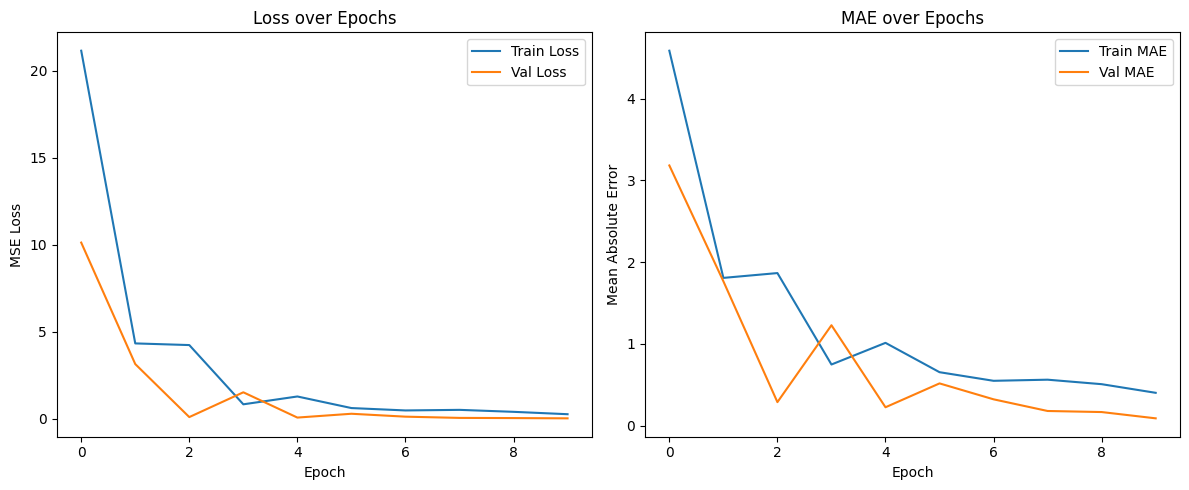

In [ ]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
# Pearson Correlation
pearson_corr, _ = pearsonr(y_val, y_pred)

# Spearman Correlation
spearman_corr, _ = spearmanr(y_val, y_pred)

print(f"📈 Pearson Correlation:  {pearson_corr:.4f}")
print(f"📊 Spearman Correlation: {spearman_corr:.4f}")


# Plot loss and MAE
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Helper function
def evaluate(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }


print(evaluate(y_val, y_pred))


{'MSE': 0.01650298573076725, 'MAE': 0.0897492915391922, 'MAPE': 0.01794985681772232, 'R²': 0.0}
